## LITL Eval

We see how the Gemini (No LITL), Gemini (With LITL), and Grok (With LITL) compare for predicting compound efficacy. Note that we redact each compound with a FB code to protect proprietary data.

In [1]:
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [ ]:
# includes proprietary assay data so not included in repo
gemini_no_lit_results_path = "0__gemini__before_litl_results.pkl"
gemini_lit_results_path = "2__gemini__after_litl_results.pkl"
grok_lit_results_path = "2__grok__after_litl_results.pkl"

with open(gemini_no_lit_results_path, "rb") as f:
    gemini_no_lit_results = pickle.load(f)

with open(gemini_lit_results_path, "rb") as f:
    gemini_lit_results = pickle.load(f)

with open(grok_lit_results_path, "rb") as f:
    grok_lit_results = pickle.load(f)

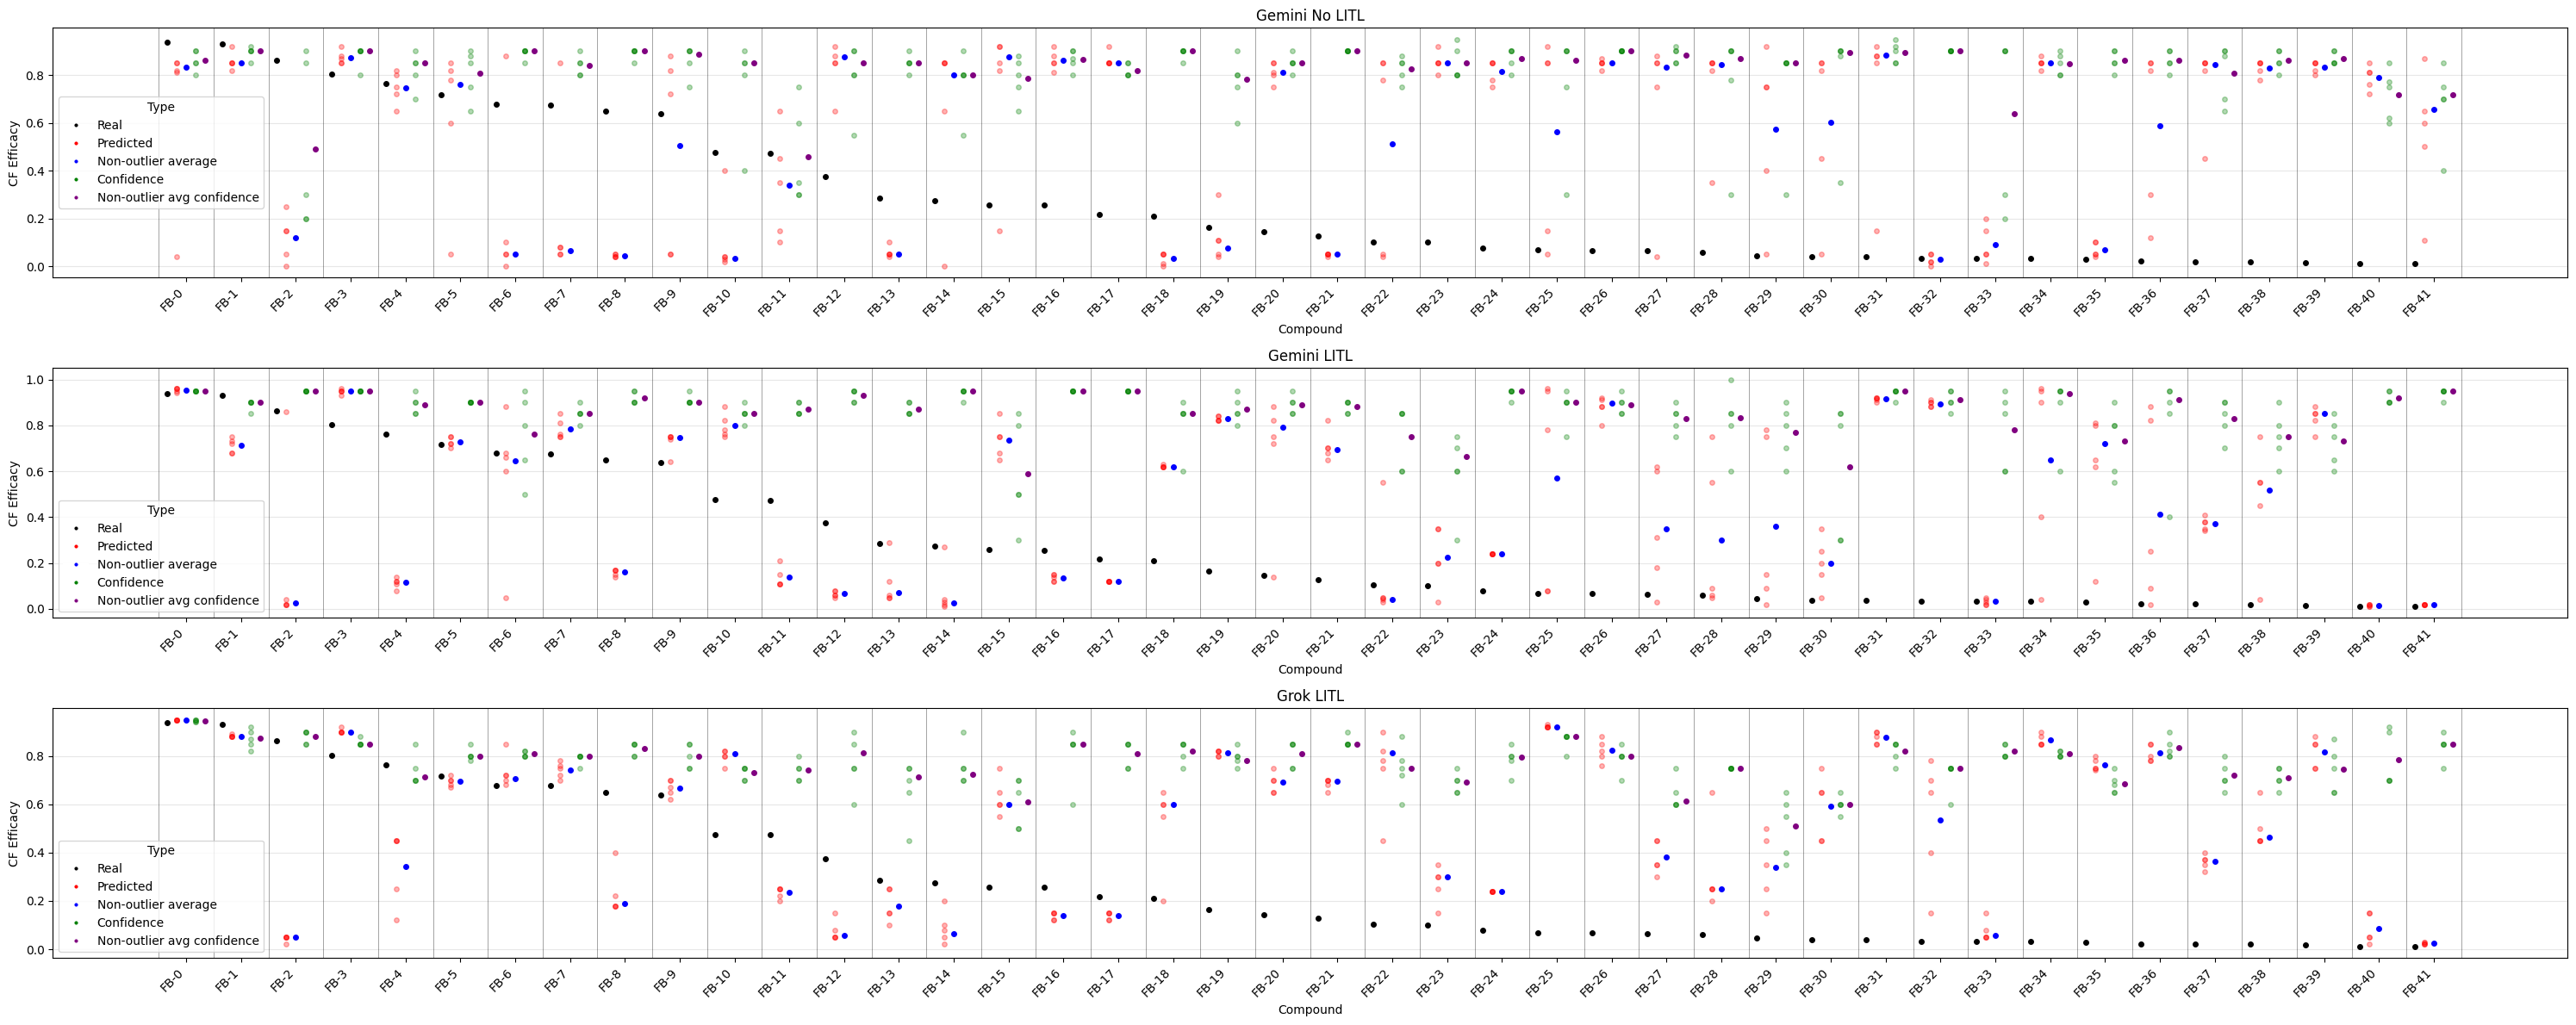

In [14]:
# Function to prepare data
def prepare_data(results, is_summarized=False):
    data = []
    real_added = set()
    for item in results:
        if is_summarized:
            example, prediction, predicted = item
        else:
            example, prediction = item
        compound = example.compound_name
        real = example.cf_efficacy
        if compound not in real_added:
            data.append({"compound": compound, "type": "real", "efficacy": real})
            real_added.add(compound)
        data.append(
            {
                "compound": compound,
                "type": "predicted",
                "efficacy": prediction.predicted_efficacy,
                "confidence": prediction.confidence,
            }
        )
    df = pd.DataFrame(data)
    compound_order = (
        df[df["type"] == "real"]
        .sort_values("efficacy", ascending=False)["compound"]
        .tolist()
    )
    return df, compound_order


# Prepare data for each
df1, order1 = prepare_data(gemini_no_lit_results["agent_runs"])
df2, order2 = prepare_data(gemini_lit_results["agent_runs"])
df3, order3 = prepare_data(grok_lit_results["agent_runs"])

# Create mapping from real compound names to redacted names
compound_to_redacted = {comp: f"FB-{i}" for i, comp in enumerate(order1)}

# Apply redaction to dataframes
df1["compound"] = df1["compound"].map(compound_to_redacted)
df2["compound"] = df2["compound"].map(compound_to_redacted)
df3["compound"] = df3["compound"].map(compound_to_redacted)

# Update orders with redacted names
order1 = [compound_to_redacted[comp] for comp in order1]
order2 = [compound_to_redacted[comp] for comp in order2]
order3 = [compound_to_redacted[comp] for comp in order3]


def non_outlier_mean(series):
    if len(series) <= 2:
        return series.mean()
    sorted_vals = sorted(series)
    n = len(sorted_vals)
    q1_idx = n // 4
    q3_idx = 3 * n // 4
    q1 = sorted_vals[q1_idx]
    q3 = sorted_vals[q3_idx]
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    filtered = series[(series >= lower) & (series <= upper)]
    return filtered.mean() if len(filtered) > 0 else series.mean()


def get_errors(df, order):
    mean_pred = (
        df[df["type"] == "predicted"]
        .groupby("compound")["efficacy"]
        .apply(non_outlier_mean)
    )
    real_df = df[df["type"] == "real"].set_index("compound")["efficacy"]
    errors = {comp: real_df.get(comp, 0) - mean_pred.get(comp, 0) for comp in order}
    return errors


error1 = get_errors(df1, order1)
error2 = get_errors(df2, order2)
error3 = get_errors(df3, order3)

# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(30, 12))

titles = ["Gemini No LITL", "Gemini LITL", "Grok LITL"]
dfs_orders = [(df1, order1), (df2, order2), (df3, order3)]

for i in range(3):
    ax = axes[i]
    title = titles[i]
    ax.set_title(title)
    df, order = dfs_orders[i]

    # Define offsets for each type of point
    offset_real = -0.35
    offset_pred = -0.175
    offset_avg = 0.0
    offset_conf = 0.175
    offset_avg_conf = 0.35

    # Plot real with offset
    real_df = df[df["type"] == "real"]
    for _, row in real_df.iterrows():
        comp = row["compound"]
        efficacy = row["efficacy"]
        if comp in order:
            x_pos = order.index(comp) + offset_real
            ax.scatter(x_pos, efficacy, color="black", s=16, alpha=1, zorder=10)

    # Plot predicted with offset
    predicted_df = df[df["type"] == "predicted"]
    for _, row in predicted_df.iterrows():
        comp = row["compound"]
        efficacy = row["efficacy"]
        if comp in order:
            x_pos = order.index(comp) + offset_pred
            ax.scatter(x_pos, efficacy, color="red", s=16, alpha=0.3, zorder=5)

    # Calculate and plot average predicted with offset
    mean_pred = (
        df[df["type"] == "predicted"]
        .groupby("compound")["efficacy"]
        .apply(non_outlier_mean)
    )
    for comp in order:
        if comp in mean_pred:
            x_pos = order.index(comp) + offset_avg
            ax.scatter(x_pos, mean_pred[comp], color="blue", s=16, zorder=10)

    # Plot confidence values with offset
    for _, row in predicted_df.iterrows():
        comp = row["compound"]
        confidence = row["confidence"]
        if comp in order:
            x_pos = order.index(comp) + offset_conf
            ax.scatter(x_pos, confidence, color="green", s=16, alpha=0.3, zorder=5)

    # Calculate and plot average confidence with offset
    mean_conf = (
        df[df["type"] == "predicted"]
        .groupby("compound")["confidence"]
        .apply(non_outlier_mean)
    )
    for comp in order:
        if comp in mean_conf:
            x_pos = order.index(comp) + offset_avg_conf
            ax.scatter(x_pos, mean_conf[comp], color="purple", s=16, zorder=10)

    # Add vertical lines to separate compounds
    for j in range(len(order) + 1):
        ax.axvline(x=j - 0.5, color="black", linewidth=0.5, alpha=0.5)

    # Add legend
    handles = [
        plt.Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            markerfacecolor="black",
            markersize=4,
            label="Real",
        ),
        plt.Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            markerfacecolor="red",
            markersize=4,
            label="Predicted",
        ),
        plt.Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            markerfacecolor="blue",
            markersize=4,
            label="Non-outlier average",
        ),
        plt.Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            markerfacecolor="green",
            markersize=4,
            label="Confidence",
        ),
        plt.Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            markerfacecolor="purple",
            markersize=4,
            label="Non-outlier avg confidence",
        ),
    ]
    ax.legend(handles=handles, title="Type")
    ax.set_ylabel("CF Efficacy")

    # Set x-axis ticks and labels
    ax.set_xticks(range(len(order)))
    ax.set_xticklabels(order, rotation=45, ha="right")
    ax.set_xlabel("Compound")

    ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()


### Main Comparison: Predicted vs Real Efficacy

This graph compares the predicted compound efficacy against real efficacy for each of the three agent configurations. For each compound, we show:
- **Black dots**: Real efficacy (ground truth)
- **Red dots**: Individual predicted efficacy values (semi-transparent to show distribution)
- **Blue dots**: Non-outlier average of predicted efficacy
- **Green dots**: Individual confidence values for each prediction
- **Purple dots**: Non-outlier average of confidence values

Compounds are ordered from highest to lowest real efficacy (left to right).

/var/folders/pc/dx9_5lnn3qz8j56zyhdcmk8w0000gn/T/ipykernel_80488/178851995.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


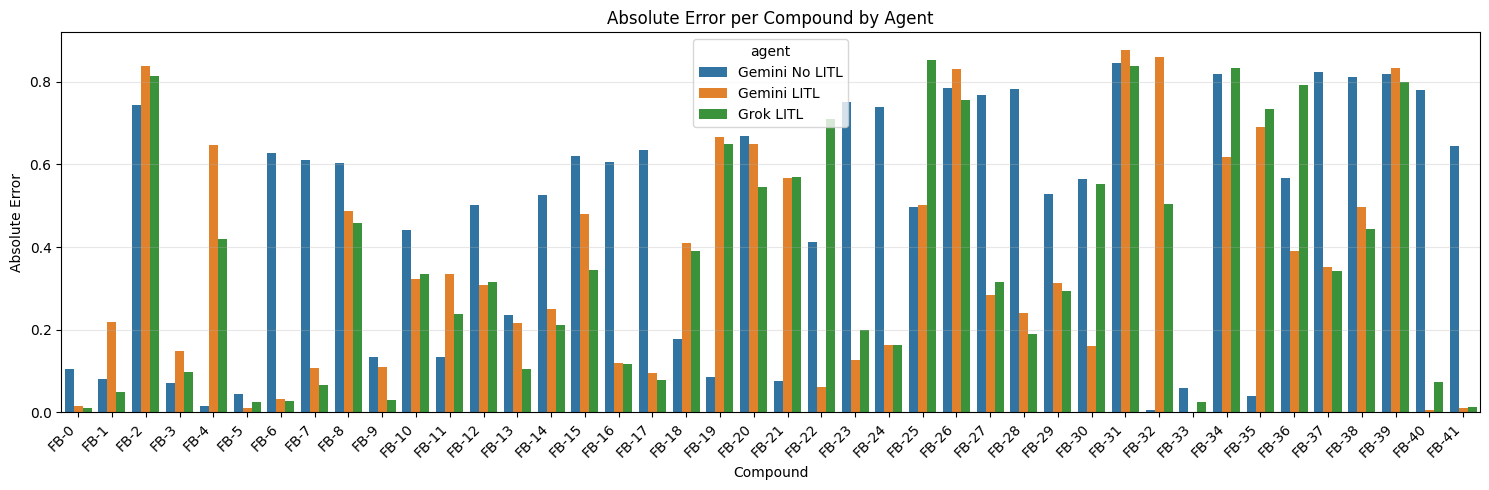

In [4]:
# Change in Error Plots

abs_errors = []
for comp in order1:
    abs_errors.append(
        {
            "compound": comp,
            "agent": "Gemini No LITL",
            "abs_error": abs(error1.get(comp, 0)),
        }
    )
    abs_errors.append(
        {
            "compound": comp,
            "agent": "Gemini LITL",
            "abs_error": abs(error2.get(comp, 0)),
        }
    )
    abs_errors.append(
        {
            "compound": comp,
            "agent": "Grok LITL",
            "abs_error": abs(error3.get(comp, 0)),
        }
    )

abs_error_df = pd.DataFrame(abs_errors)

fig, ax = plt.subplots(figsize=(15, 5))

sns.barplot(
    data=abs_error_df, x="compound", y="abs_error", hue="agent", order=order1, ax=ax
)
ax.set_title("Absolute Error per Compound by Agent")
ax.set_ylabel("Absolute Error")
ax.set_xlabel("Compound")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

### Absolute Error per Compound

This bar chart shows the absolute error (|predicted - real|) for each compound across the three agents. Lower bars indicate better predictions. This helps identify which compounds are harder to predict and which agent performs best for each compound.

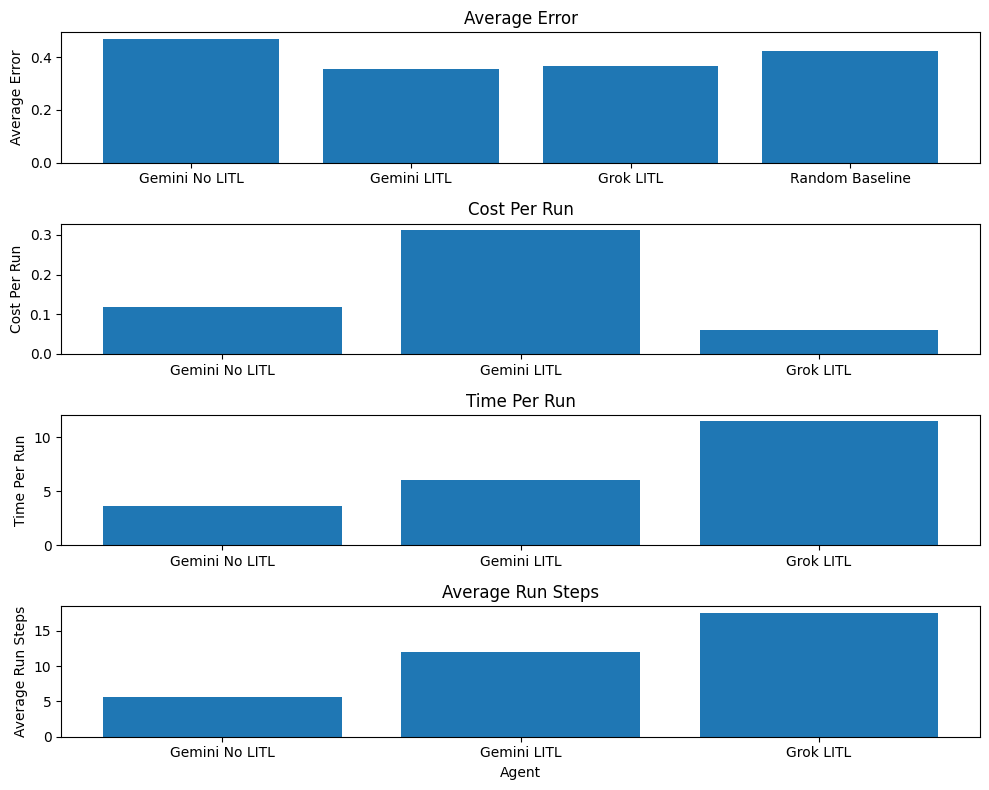

In [5]:
# Agent Comparison Metrics

import numpy as np

avg_errors = [
    np.mean([abs(v) for v in error1.values()]),
    np.mean([abs(v) for v in error2.values()]),
    np.mean([abs(v) for v in error3.values()]),
]


# Calculate average run steps
def get_avg_steps(results, is_summarized=False):
    steps_list = []
    for item in results:
        if is_summarized:
            example, prediction, predicted = item
        else:
            example, prediction = item
        steps = len(prediction.trajectory) // 4
        steps_list.append(steps)
    return np.mean(steps_list)


avg_steps1 = get_avg_steps(gemini_no_lit_results["agent_runs"])
avg_steps2 = get_avg_steps(gemini_lit_results["agent_runs"])
avg_steps3 = get_avg_steps(grok_lit_results["agent_runs"])

run_steps = [avg_steps1, avg_steps2, avg_steps3]

# Actual costs and times
num_runs1 = len(gemini_no_lit_results["agent_runs"])
num_runs2 = len(gemini_lit_results["agent_runs"])
num_runs3 = len(grok_lit_results["agent_runs"])

costs = [
    gemini_no_lit_results["cost"] / num_runs1,
    gemini_lit_results["cost"] / num_runs2,
    grok_lit_results["cost"] / num_runs3,
]

times = [
    gemini_no_lit_results["time"] / num_runs1,
    gemini_lit_results["time"] / num_runs2,
    grok_lit_results["time"] / num_runs3,
]

agents = ["Gemini No LITL", "Gemini LITL", "Grok LITL"]
metrics = [
    "Average Error",
    "Cost Per Run",
    "Time Per Run",
    "Average Run Steps",
]
values = [avg_errors, costs, times, run_steps]

# Random baseline
import random

random.seed(0)
real_df = df1[df1["type"] == "real"].set_index("compound")["efficacy"]
random_errors = []
for comp in order1:
    real = real_df.get(comp, 0)
    random_pred = random.uniform(0, 1)
    error = real - random_pred
    random_errors.append(abs(error))
random_avg_error = np.mean(random_errors)

avg_errors.append(random_avg_error)
costs.append(np.nan)
times.append(np.nan)
run_steps.append(np.nan)
agents.append("Random Baseline")

fig, axes = plt.subplots(4, 1, figsize=(10, 8))

for i in range(4):
    ax = axes[i]
    ax.bar(agents, values[i])
    ax.set_title(metrics[i])
    ax.set_ylabel(metrics[i])
    if i == 3:
        ax.set_xlabel("Agent")

plt.tight_layout()
plt.show()

### Agent Performance Metrics

Comparison of key performance metrics across agents:
- **Average Error**: Mean absolute error across all compounds (lower is better)
- **Cost Per Run**: Average cost in dollars per compound prediction
- **Time Per Run**: Average time in seconds per compound prediction
- **Average Run Steps**: Average number of agent reasoning steps per prediction

The random baseline is included to show what random guessing would achieve.

### Hit Prediction Accuracy

Given an arbitrary hit threshold for efficacy, how well does each LITL system predict hit and non-hit compounds? A compound is considered a "hit" if its efficacy is above the threshold. We measure accuracy as the percentage of compounds where the agent correctly classifies them as hit or non-hit.

In [32]:
# Define hit threshold
HIT_THRESHOLD = 0.6

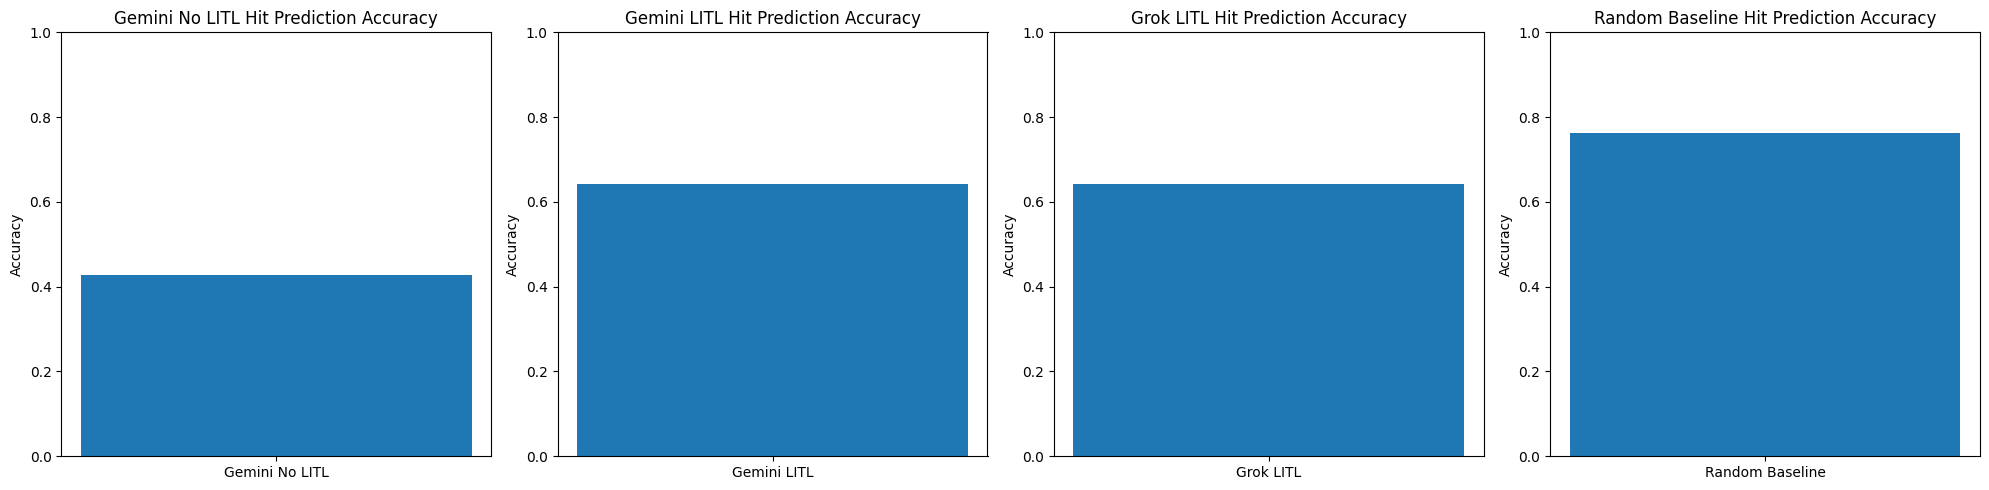

In [33]:
# Hit Prediction Accuracy


def compute_accuracy(df, order, hit_threshold=HIT_THRESHOLD):
    mean_pred = (
        df[df["type"] == "predicted"]
        .groupby("compound")["efficacy"]
        .apply(non_outlier_mean)
    )
    real_df = df[df["type"] == "real"].set_index("compound")["efficacy"]
    correct = 0
    total = 0
    for comp in order:
        if comp in mean_pred.index and comp in real_df.index:
            pred_hit = mean_pred[comp] > hit_threshold
            real_hit = real_df[comp] > hit_threshold
            if pred_hit == real_hit:
                correct += 1
            total += 1
    return correct / total if total > 0 else 0


acc1 = compute_accuracy(df1, order1)
acc2 = compute_accuracy(df2, order2)
acc3 = compute_accuracy(df3, order3)

# Random baseline
random.seed(0)
real_df = df1[df1["type"] == "real"].set_index("compound")["efficacy"]
correct = 0
total = 0
for comp in order1:
    real = real_df.get(comp, 0)
    random_preds = [random.uniform(0, 1) for _ in range(100)]
    mean_pred = non_outlier_mean(pd.Series(random_preds))
    pred_hit = mean_pred > HIT_THRESHOLD
    real_hit = real > HIT_THRESHOLD
    if pred_hit == real_hit:
        correct += 1
    total += 1
acc4 = correct / total if total > 0 else 0

agents = ["Gemini No LITL", "Gemini LITL", "Grok LITL", "Random Baseline"]
accuracies = [acc1, acc2, acc3, acc4]

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for i in range(4):
    axes[i].bar([agents[i]], [accuracies[i]])
    axes[i].set_title(f"{agents[i]} Hit Prediction Accuracy")
    axes[i].set_ylabel("Accuracy")
    axes[i].set_ylim(0, 1)

plt.tight_layout()
plt.show()

### Hit Prediction Accuracy vs Confidence Cutoff

How does hit prediction accuracy change when we only consider predictions with confidence above a certain threshold? If agent confidence is correlated with accuracy, we expect to see accuracy increase with a higher confidence cutoff.

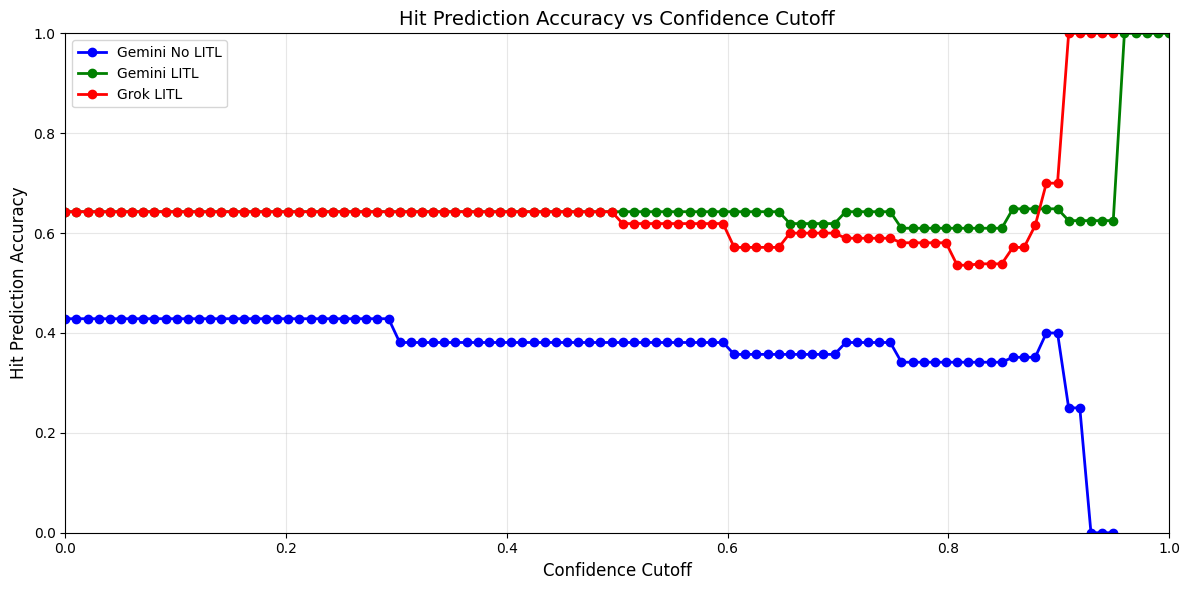

In [34]:
# Hit Prediction Accuracy vs Confidence Cutoff


def compute_accuracy_with_confidence_cutoff(
    df, order, confidence_cutoff=0.0, hit_threshold=HIT_THRESHOLD
):
    """
    Compute accuracy only for predictions with confidence >= confidence_cutoff.
    If no predictions meet the cutoff for a compound, that compound is skipped.
    """
    # Filter predictions by confidence
    filtered_df = df[
        (df["type"] == "predicted") & (df["confidence"] >= confidence_cutoff)
    ]

    if len(filtered_df) == 0:
        return None  # No predictions meet the cutoff

    mean_pred = filtered_df.groupby("compound")["efficacy"].apply(non_outlier_mean)
    real_df = df[df["type"] == "real"].set_index("compound")["efficacy"]

    correct = 0
    total = 0
    for comp in order:
        if comp in mean_pred.index and comp in real_df.index:
            pred_hit = mean_pred[comp] > hit_threshold
            real_hit = real_df[comp] > hit_threshold
            if pred_hit == real_hit:
                correct += 1
            total += 1

    return correct / total if total > 0 else None


# Test different confidence cutoffs
confidence_cutoffs = np.linspace(0, 1, 100)

results = {
    "Gemini No LITL": [],
    "Gemini LITL": [],
    "Grok LITL": [],
}

dfs_for_cutoff = [
    ("Gemini No LITL", df1, order1),
    ("Gemini LITL", df2, order2),
    ("Grok LITL", df3, order3),
]

for cutoff in confidence_cutoffs:
    for agent_name, df, order in dfs_for_cutoff:
        acc = compute_accuracy_with_confidence_cutoff(df, order, cutoff)
        results[agent_name].append(acc)

# Create line plot
fig, ax = plt.subplots(figsize=(12, 6))

colors = {"Gemini No LITL": "blue", "Gemini LITL": "green", "Grok LITL": "red"}

for agent_name in ["Gemini No LITL", "Gemini LITL", "Grok LITL"]:
    ax.plot(
        confidence_cutoffs,
        results[agent_name],
        marker="o",
        label=agent_name,
        color=colors[agent_name],
        linewidth=2,
    )

ax.set_xlabel("Confidence Cutoff", fontsize=12)
ax.set_ylabel("Hit Prediction Accuracy", fontsize=12)
ax.set_title("Hit Prediction Accuracy vs Confidence Cutoff", fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 1)
ax.set_xlim(0, 1)

plt.tight_layout()
plt.show()